In [1]:
from utils.binaries import *
from utils.plotting import *
from itertools import product

12:56:49 (   +2.3s) [INFO   ] -- import logging
12:56:49 (  +143ms) [INFO   ] -- import numpy as np
12:56:49 (    +6ms) [INFO   ] -- import uncertainties
12:56:50 (  +424ms) [INFO   ] -- import pandas as pd
12:56:50 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
12:56:50 (    +2ms) [INFO   ] -- import binaries.tools as tools
12:56:50 (  +378ms) [INFO   ] -- import matplotlib.pyplot as plt
12:56:51 (  +498ms) [INFO   ] -- import seaborn as so
12:56:51 (    +2ms) [INFO   ] -- import plotting.tools as plot
12:56:51 (   +12ms) [DEBUG  ] -- font size set to 9.5
12:56:51 (    +1ms) [DEBUG  ] -- label size set to 13.0
12:56:51 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
12:56:51 (    +1ms) [DEBUG  ] -- markersize set to 2.0
12:56:51 (    +0ms) [DEBUG  ] -- usetex set to False


In [10]:
def read(station):

    multiplicities = range(5, 45)
    threshold = np.linspace(0.05, 3.00, 295)
    all_params = list(product(multiplicities, threshold))

    base = "/cr/data01/filip/Data/SSDtotRateMap/"
    data = np.loadtxt(f"{base}/{station}_SSD.txt")
    container = np.empty((4, len(all_params)))
    container[:] = np.nan
    x, y, z1, z2 = container

    for row in data:
        x_, y_, z_tot, z_totd, t = row
        # print(x_, y_, z_tot, z_totd, t)

        for this_index, (_x, _y) in enumerate(all_params):
            if _x == x_ and _y == y_:
                break

        x[this_index] = x_
        y[this_index] = y_
        z1[this_index] = z_tot
        z2[this_index] = z_totd

    assert (
        len(DAQ_seconds := np.unique(data[:, 4])) == 1
    ), f"DAQ time(s) do not match: {DAQ_seconds = }"

    return x, y, z1, z2, *DAQ_seconds


def visualize(data, l=None):

    multiplicities = range(5, 45)
    threshold = np.linspace(0.05, 3.00, 295)

    x, y, z1, z2, time = data
    z1 = z1.reshape((len(multiplicities), len(threshold))) / time
    z2 = z2.reshape((len(multiplicities), len(threshold))) / time
    fig, ax1 = plt.subplots(1, 1)

    # formatter = lambda x : fr'$10^{int(np.log10(x))}$ Hz'
    formatter = lambda x: f"{int(x) if int(x) != 0 else x} Hz"

    for ax, z, trigger in zip([ax1], [z1, z2], ["ToT", "ToTd"]):

        # ax.set_box_aspect(1)
        image = ax.imshow(
            z.T,
            extent=(5, 45, 0.05, 3.00),
            aspect="auto",
            cmap="viridis",
            origin="lower",
            norm="log",
            interpolation="none",
            vmin=0.01,
            vmax=200,
        )
        if l is not None:
            levels = ax.contour(
                z.T,
                levels=l,
                extent=(5, 45, 0.05, 3.00),
                origin="lower",
                alpha=0.9,
                colors="k",
                norm="log",
                vmin=0.01,
                vmax=200,
            )
            ax.clabel(
                levels,
                colors="k",
                fontsize=9,
                inline=True,
                inline_spacing=10,
                fmt=formatter,
            )

        ax.set_ylabel("threshold / $I^\mathrm{SSD}_\mathrm{histo}$")
        ax.set_xlabel("occupancy / bins")

        # ax.annotate('current', (13, 0.2), (13, 0.21), horizontalalignment='right')
        # ax.scatter(13, 0.2, marker='v', s=15, c='r')

        ax.set_title(f"SSD-{trigger}, {time:.1f} s of DAQ")
        plt.colorbar(image, label="T2 rate / Hz")
        ax.minorticks_off()

    # yticks = np.arange(0, 0.241, 0.02)
    # _ = ax.set_yticks(yticks[::2], [f"{x/0.2:.1f}" for x in yticks[::2]])

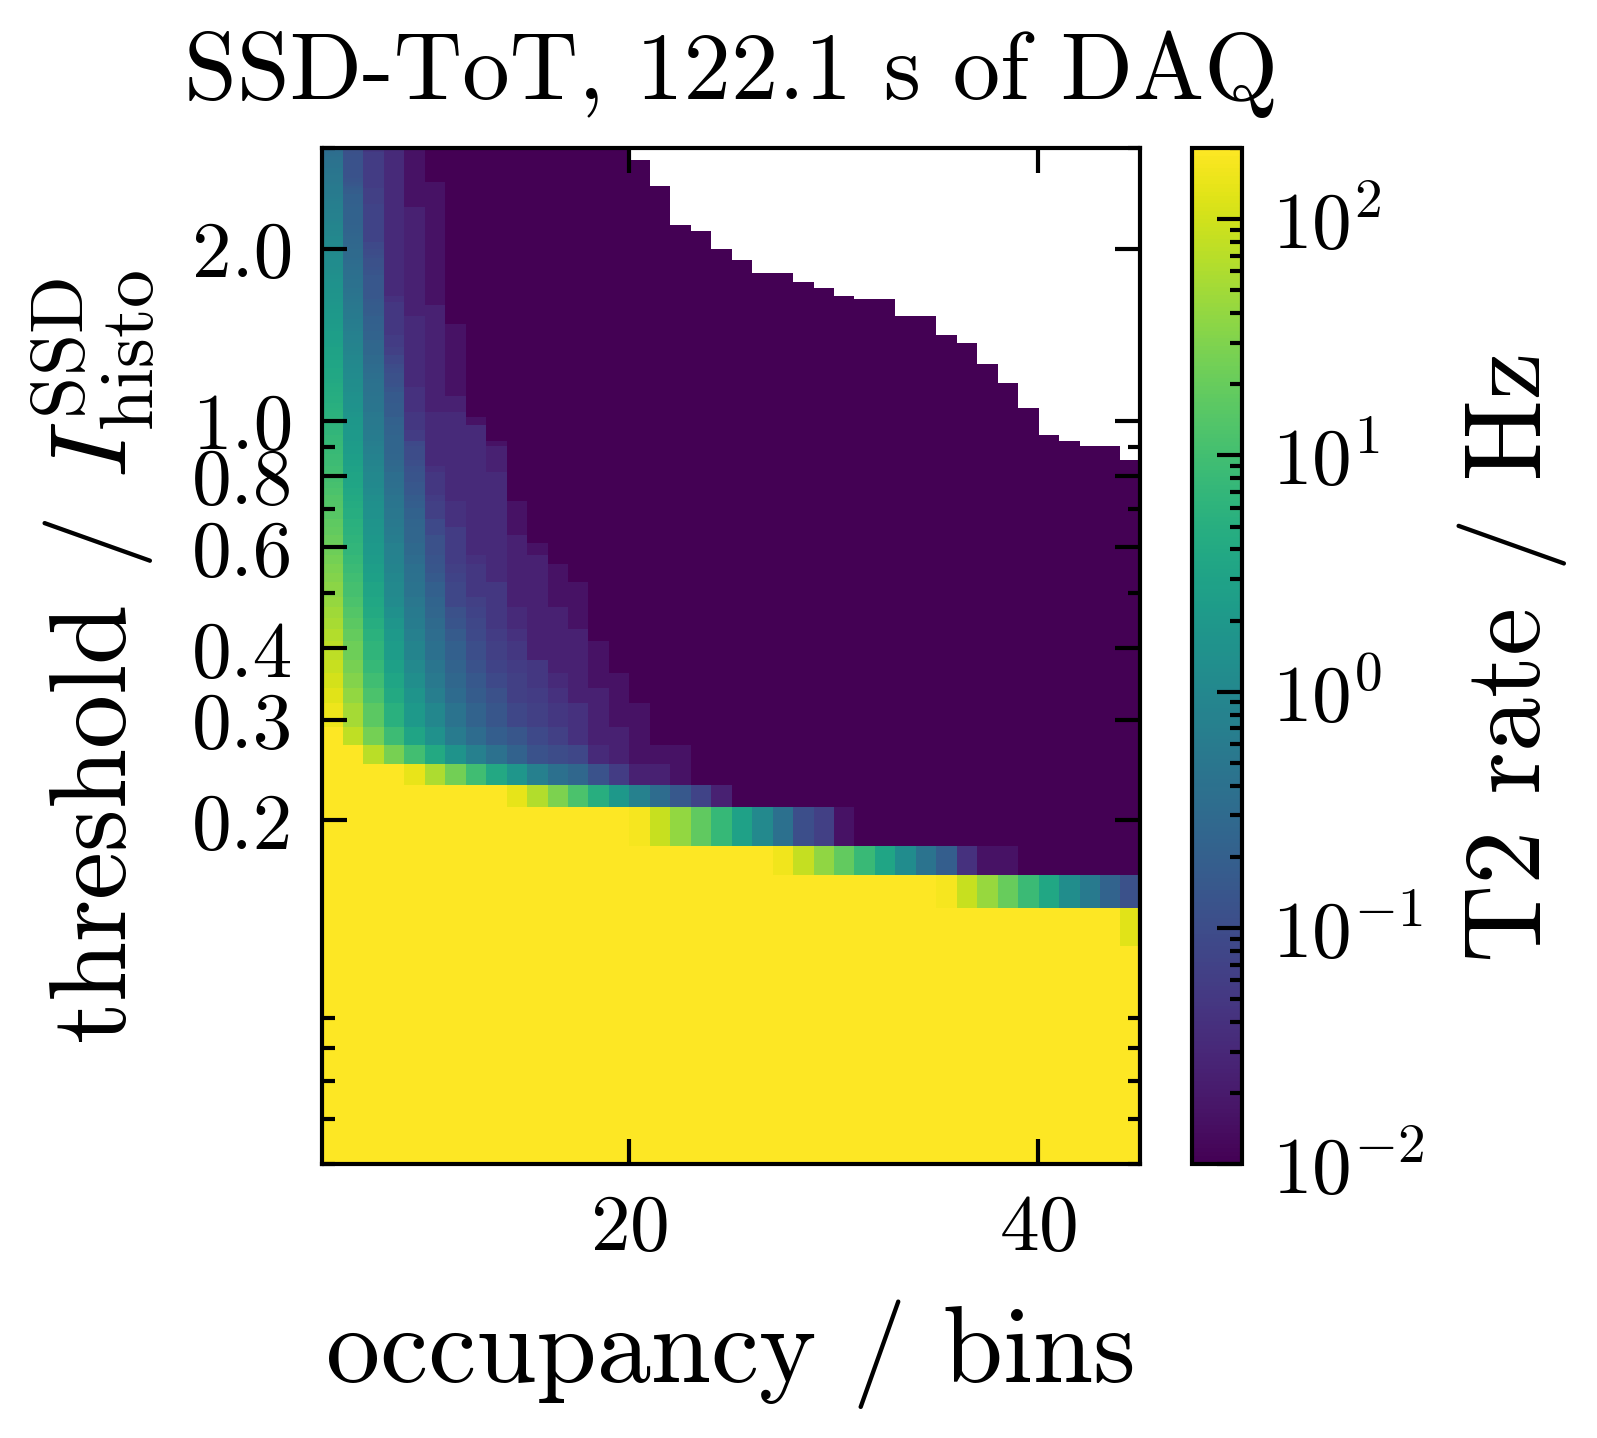

In [16]:
for station in ["Nadia"]:
    data_nadia = read(station)
    visualize(data_nadia)
    # plt.subplots_adjust(wspace=0.5)
    # plt.savefig(f'/cr/data01/filip/plots/UubRandoms/ssd_tot_rate_maps/{station}.png')

# plt.xlim(15, 20)
# plt.ylim(0.2, 3)
plt.yscale("log")
_ = plt.yticks(
    [0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 2.0],
    ["0.2", "0.3", "0.4", "0.6", "0.8", "1.0", "2.0"],
)

plt.gcf().set_figheight(2.2)
plt.gcf().set_figwidth(2.2)

# plt.xlim(5, 25)
# plt.ylim(0.2, 2)